<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Проект-для-Викишоп" data-toc-modified-id="Проект-для-Викишоп-1">Проект для Викишоп</a></span><ul class="toc-item"><li><span><a href="#1.1-Загрузка-и-подготовка-данных" data-toc-modified-id="1.1-Загрузка-и-подготовка-данных-1.1">1.1 Загрузка и подготовка данных</a></span></li><li><span><a href="#1.2-Обработка,-токенизация,-лемматизация-данных" data-toc-modified-id="1.2-Обработка,-токенизация,-лемматизация-данных-1.2">1.2 Обработка, токенизация, лемматизация данных</a></span></li><li><span><a href="#2.-Векторизация-и-обучение-моделей" data-toc-modified-id="2.-Векторизация-и-обучение-моделей-1.3">2. Векторизация и обучение моделей</a></span></li><li><span><a href="#2.1-LogisticRegression" data-toc-modified-id="2.1-LogisticRegression-1.4">2.1 LogisticRegression</a></span></li><li><span><a href="#2.2-DecisionTreeClassifier" data-toc-modified-id="2.2-DecisionTreeClassifier-1.5">2.2 DecisionTreeClassifier</a></span></li><li><span><a href="#2.3-RandomForestClassifier" data-toc-modified-id="2.3-RandomForestClassifier-1.6">2.3 RandomForestClassifier</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.7">Вывод</a></span></li></ul></li></ul></div>

# Проект для Викишоп

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Ход проекта:**
1. Загрузка и подготовка данных
2. Обучение моделей
3. Вывод

Наша целевая метрика: F1 не меньше 0.75

## 1.1 Загрузка и подготовка данных

In [1]:
!pip install nltk -q

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

# модели для обучения
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
#from scipy.stats import randint

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
try:
    df = pd.read_csv("/content/toxic_comments.csv")
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')
df.head(5)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Удалим ненужный столбец Unnamed: 0, и поверим данные на наличие пропусков и дубликатов; в столбце toxic посомтрим на уникальные значения.

In [4]:
df = df.drop(columns=['Unnamed: 0'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
df.duplicated().sum()

0

In [7]:
df.toxic.unique()

array([0, 1])

Проверим данные на дисаланс классов

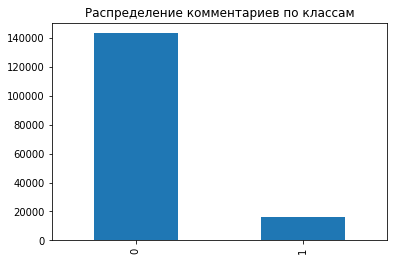

In [8]:
df['toxic'].value_counts().plot(kind='bar')
plt.title('Распределение комментариев по классам')
plt.show()

Мы видим очень сильный дисбаланс, поэтому при составлении выборов будем это иметь ввиду.

С данными все впорядке, переходим к лемматизации, токенизации

## 1.2 Обработка, токенизация, лемматизация данных

In [9]:
texts = list(df['text'])
toxic = list(df['toxic'])

In [10]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

Напишем функцию, которая будет нам обрабатывать текст - уберет лишние знаки, проведет токенизацию и лемматизацию.

In [11]:
def get_wordnet_pos(treebank_tag):
    return {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }.get(treebank_tag[0], wordnet.NOUN)

def clean_text(text):
    text = re.sub(r"[^a-zA-Z' ]", " ", str(text))
    text = re.sub(r"\s+", " ", text).strip().lower()
    return text

def lemmatize_with_pos(text):
    tokens = word_tokenize(str(text))
    pos_tags = pos_tag(tokens)
    return " ".join([
        lemmatizer.lemmatize(token.lower(), pos=get_wordnet_pos(tag))
        for token, tag in pos_tags
        if token.lower() not in stop_words and len(token) > 2 and token.isalpha()
    ])

In [12]:
df["cleaned_text"] = df["text"].apply(clean_text)

df["lemmatized_text"] = df["cleaned_text"].apply(lemmatize_with_pos)

In [13]:
df.head(5)

,text,toxic,cleaned_text,lemmatized_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,d'aww he matches this background colour i'm se...,match background colour seemingly stick thanks...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really not trying to edit war it's...,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can't make any real suggestions on impr...,make real suggestion improvement wonder sectio...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,sir hero chance remember page


Данные обработали, перейдем к векторизации данных с помощью TF-IDF и обучению моделей. При использовании TF-IDF векторизации мы должны обучать ее только на тренировочных данных во избежание утечки.

## 2. Векторизация и обучение моделей

Мы будем использовать 3 модели:
- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier

Сделаем тренировочную и тестовую выборки, породбор параметров и качество будем осуществлять с помощью GridSearchCV и RandomSearchCV на тренировочной выборке. Также мы ранее удостоверились в том, что классы комментариев неравномерны, поэтому в `train_test_split` передадим аргумент `stratify=y`.

In [14]:
X = df['lemmatized_text']
y = df['toxic']


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,
    random_state=42
)

In [15]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
x_test_tfidf = tfidf.transform(X_test)

## 2.1 LogisticRegression

In [16]:
model_lr = LogisticRegression()

param_grid_lr = {
    'penalty': ['l2', None],
    'C': [0.01, 0.2, 0.5, 1],
}

gs_lr = RandomizedSearchCV(
    model_lr,
    param_distributions=param_grid_lr,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1,
    n_iter=5
)

gs_lr.fit(X_val_tfidf, y_val)
best_params_lr = gs_lr.best_params_


display(f'best_score: {gs_lr.best_score_}')
f'best_params: {gs_lr.best_params_}'

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Посмотрим как справится модель DecisionTreeClassifier

## 2.2 DecisionTreeClassifier

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)

param_dist_dt = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10],
    #'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced']
}

rs_dt = RandomizedSearchCV(
    dt_model,
    param_distributions=param_dist_dt,
    n_iter=5,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rs_dt.fit(X_val_tfidf, y_val)

best_params_dt = rs_dt.best_params_

display(f'best_score: {rs_dt.best_score_}')
f'best_params: {rs_dt.best_params_}'

## 2.3 RandomForestClassifier

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200, 250],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10],
    'class_weight': [None, 'balanced']
}
rs_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist_dt,
    n_iter=5,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rs_rf.fit(X_val_tfidf, y_val)

best_params_rf = rs_rf.best_params_

display(f'best_score: {rs_rf.best_score_}')
f'best_params: {rs_rf.best_params_}'

Лучше всех справилась модель логистической регрессии. Сделаем предсказания на тестовой выборке.

In [ ]:
best_model = gs_lr.best_estimator_
predictions = best_model.predict(x_test_tfidf)

In [ ]:
f1_score_test = f1_score(y_test, predictions)

In [ ]:
f1_score_test

Метрика F1 на тестовой выборке равна 0.757, что подходит нам по условиям задачи.

##  Вывод

Мы обработали тексты твитов с помощью библиотеки nltk, затем векторизировали текст с помощью TF-IDF. Также мы обучили три модели:
- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier,
для каждой подобрали параметры с помощью RandomizedSearchCV.

 Лучше всех себя показала модель Logistic Regression с параметрами `C: 0.01`, `penalty: None`, и f1 на подборе гиперпараметров равной 0.75704. На тестовой выборке данная модель с лучшими параметрами сработала лучше, f1 = 0.75754